# Multi-Task Edit Calculus: Edit Embeddings vs. Property Prediction

This notebook compares **two approaches** for predicting property changes:

## 🎯 The Question:
**Does learning shared edit embeddings across tasks improve property change prediction?**

## 🔬 Two Approaches:

### **Edit Framework (Our Approach):**
- Learns **shared edit embeddings** across 5 biological properties
- Directly predicts: `(mol_a, mol_b) → Δproperty`
- Hypothesis: Edit patterns transfer across tasks

### **Baseline (Property Predictor):**
- Learns **molecule property values**
- Predicts: `mol → property`, then computes `Δ = property_b - property_a`
- No explicit edit concept

## 📊 Fair Comparison:
- Both use multi-task learning (5 tasks)
- Both use shared representations + task-specific heads
- Same data, architecture size, training procedure
- **Only difference**: Edit embeddings vs. molecule embeddings

## 1. Configuration

In [1]:
DATA_FILE = '../data/pairs/chembl_pairs_long_sample.csv'
MIN_PAIRS_PER_PROPERTY = 3000
NUM_TASKS = 10

# Split
TRAIN_RATIO = 0.70
VAL_RATIO = 0.15
TEST_RATIO = 0.15
RANDOM_SEED = 42

# Molecule Embedder Selection
# Options: 'morgan', 'rdkit', 'maccs', 'atompair', 'chemberta', 'chemprop'
EMBEDDER_TYPE = 'chemprop'

# Morgan fingerprint parameters (used if EMBEDDER_TYPE is 'morgan', 'rdkit', etc.)
FP_TYPE = 'chemberta'
FP_RADIUS = 2
FP_BITS = 2048

# Model architecture (same for both)
TRAINABLE_EDIT_DIMS = [1024, 512]  # Edit embedding layers
HIDDEN_DIMS = [512, 256, 128, 64]   # Shared backbone (increased capacity for baseline)
DROPOUT = 0.2

# Training (same for both)
LEARNING_RATE = 1e-3
BATCH_SIZE = 128
MAX_EPOCHS = 5

print("✓ Configuration loaded")


✓ Configuration loaded


In [2]:
import sys
from pathlib import Path
sys.path.insert(0, str(Path.cwd().parent))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations

import torch
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN

# Check embedder availability
try:
    from transformers import AutoTokenizer, AutoModel
    CHEMBERTA_AVAILABLE = True
except ImportError:
    CHEMBERTA_AVAILABLE = False

try:
    import chemprop
    CHEMPROP_AVAILABLE = True
except ImportError:
    CHEMPROP_AVAILABLE = False

from src.embedding.small_molecule import (
    FingerprintEmbedder,
    ChemBERTaEmbedder,
    ChemPropEmbedder
)
from src.models import EditEffectPredictor, PropertyPredictor
from src.utils.embedding_cache import (
    EmbeddingCache,
    compute_all_embeddings_once,
    map_embeddings_to_pairs,
    map_embeddings_to_molecules
)

# Configuration
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

%matplotlib inline


## 2. Find 5 Properties with Maximum Shared Edits

In [3]:
print("Loading data...")
df_long = pd.read_csv(DATA_FILE)

print(f"Dataset: {len(df_long):,} rows, {df_long['property_name'].nunique()} properties")

# Get candidates with sufficient pairs
prop_counts = df_long.groupby('property_name').size().sort_values(ascending=False)
candidates = prop_counts[prop_counts >= MIN_PAIRS_PER_PROPERTY].index.tolist()

# Build edit sets
prop_edit_sets = {}
for prop in candidates:
    prop_edit_sets[prop] = set(df_long[df_long['property_name'] == prop]['edit_name'])

# Find best combination with maximum shared edits
print(f"Finding {NUM_TASKS} properties with maximum shared edits...")

best_combo = None
best_shared = 0

for combo in combinations(list(prop_edit_sets.keys())[:12], NUM_TASKS):
    shared = prop_edit_sets[combo[0]].copy()
    for prop in combo[1:]:
        shared &= prop_edit_sets[prop]

    if len(shared) > best_shared:
        best_shared = len(shared)
        best_combo = combo

selected_properties = list(best_combo)

print(f"\nSelected {NUM_TASKS} properties ({best_shared} shared edits):")
for i, prop in enumerate(selected_properties, 1):
    print(f"{i}. {prop}")


Loading data...
Dataset: 1,881,223 rows, 27 properties
Finding 10 properties with maximum shared edits...

Selected 10 properties (3 shared edits):
1. d(2)_dopamine_recept_ki
2. epidermal_growth_fac_ic50
3. beta_secretase_1_ic50
4. voltage_gated_inward_ic50
5. vascular_endothelial_ic50
6. voltage_gated_inward_ki
7. d(2)_dopamine_recept_ic50
8. tyrosine_protein_kin_ic50
9. beta_secretase_1_ki
10. vascular_endothelial_ki


## 3. Prepare Datasets

In [4]:
# Filter to edits appearing in multiple properties
df_filtered = df_long[df_long['property_name'].isin(selected_properties)].copy()

edit_property_counts = df_filtered.groupby('edit_name')['property_name'].nunique()
multi_property_edits = edit_property_counts[edit_property_counts > 1].index
df_filtered = df_filtered[df_filtered['edit_name'].isin(multi_property_edits)].copy()

print(f"\nFiltered: {len(df_filtered):,} pairs, {len(multi_property_edits):,} edits (appearing in >1 property)")



Filtered: 201,137 pairs, 9,016 edits (appearing in >1 property)


In [5]:
# Split per property
splits = {}
print(f"\nSplitting (train={TRAIN_RATIO}, val={VAL_RATIO}, test={TEST_RATIO}):\n")

for prop in selected_properties:
    data = df_filtered[df_filtered['property_name'] == prop][[
        'mol_a', 'mol_b', 'edit_name', 'value_a', 'value_b', 'delta'
    ]].copy()
    
    train, temp = train_test_split(data, test_size=(VAL_RATIO+TEST_RATIO), random_state=RANDOM_SEED)
    val, test = train_test_split(temp, test_size=TEST_RATIO/(VAL_RATIO+TEST_RATIO), random_state=RANDOM_SEED)
    
    splits[prop] = {'train': train, 'val': val, 'test': test}
    print(f"  {prop:40s} | {len(train):4,} / {len(val):3,} / {len(test):3,}")


Splitting (train=0.7, val=0.15, test=0.15):

  d(2)_dopamine_recept_ki                  | 28,857 / 6,184 / 6,184
  epidermal_growth_fac_ic50                | 20,799 / 4,457 / 4,457
  beta_secretase_1_ic50                    | 7,615 / 1,632 / 1,632
  voltage_gated_inward_ic50                | 39,525 / 8,470 / 8,470
  vascular_endothelial_ic50                | 20,836 / 4,465 / 4,465
  voltage_gated_inward_ki                  | 13,350 / 2,861 / 2,861
  d(2)_dopamine_recept_ic50                | 1,720 / 369 / 369
  tyrosine_protein_kin_ic50                | 1,889 / 405 / 405
  beta_secretase_1_ki                      | 5,662 / 1,213 / 1,214
  vascular_endothelial_ki                  |  539 / 116 / 116


### 3.1 Prepare Data for Edit Framework

In [6]:
# Combine into multi-task format with sparse labels (NaN for unmeasured)
def combine_for_edit_framework(split_name):
    """Create dataset for EditEffectPredictor: (mol_a, mol_b) → Δproperty"""
    all_data = []
    for i, prop in enumerate(selected_properties):
        data = splits[prop][split_name][['mol_a', 'mol_b', 'edit_name', 'delta']].copy()
        data['property_idx'] = i
        all_data.append(data)
    return pd.concat(all_data, ignore_index=True)

train_edit = combine_for_edit_framework('train')
val_edit = combine_for_edit_framework('val')
test_edit = combine_for_edit_framework('test')

print(f"\nEdit Framework Datasets:")
print(f"  Train: {len(train_edit):5,} pairs")
print(f"  Val:   {len(val_edit):5,} pairs")
print(f"  Test:  {len(test_edit):5,} pairs")

# Prepare arrays with sparse labels
def prepare_edit_arrays(df):
    smiles_a = df['mol_a'].values
    smiles_b = df['mol_b'].values
    delta = np.full((len(df), NUM_TASKS), np.nan, dtype=np.float32)
    
    for i, prop in enumerate(selected_properties):
        mask = df['property_idx'] == i
        delta[mask, i] = df.loc[mask, 'delta'].values
    
    return smiles_a, smiles_b, delta

smiles_a_train_edit, smiles_b_train_edit, delta_train_edit = prepare_edit_arrays(train_edit)
smiles_a_val_edit, smiles_b_val_edit, delta_val_edit = prepare_edit_arrays(val_edit)
smiles_a_test_edit, smiles_b_test_edit, delta_test_edit = prepare_edit_arrays(test_edit)

print(f"\n  Label shape: {delta_train_edit.shape} (sparse, 1 task per row)")


Edit Framework Datasets:
  Train: 140,792 pairs
  Val:   30,172 pairs
  Test:  30,173 pairs

  Label shape: (140792, 10) (sparse, 1 task per row)


### 3.2 Prepare Data for Baseline (Property Predictor)

In [7]:
# Create molecule-level dataset: each pair becomes 2 samples
def create_baseline_dataset(split_name):
    """Create dataset for PropertyPredictor: mol → property
    
    Each pair (mol_a, mol_b, value_a, value_b) becomes:
      - Sample 1: (mol_a, value_a, property)
      - Sample 2: (mol_b, value_b, property)
    """
    all_molecules = []
    
    for i, prop in enumerate(selected_properties):
        data = splits[prop][split_name]
        
        # mol_a samples
        mol_a_samples = pd.DataFrame({
            'smiles': data['mol_a'].values,
            'property_value': data['value_a'].values,
            'property_idx': i
        })
        
        # mol_b samples
        mol_b_samples = pd.DataFrame({
            'smiles': data['mol_b'].values,
            'property_value': data['value_b'].values,
            'property_idx': i
        })
        
        all_molecules.append(mol_a_samples)
        all_molecules.append(mol_b_samples)
    
    return pd.concat(all_molecules, ignore_index=True)

train_baseline = create_baseline_dataset('train')
val_baseline = create_baseline_dataset('val')
test_baseline = create_baseline_dataset('test')

print(f"\nBaseline Datasets:")
print(f"  Train: {len(train_baseline):5,} molecules (2x pairs)")
print(f"  Val:   {len(val_baseline):5,} molecules")
print(f"  Test:  {len(test_baseline):5,} molecules")

# Prepare arrays with sparse labels (same format as edit framework)
def prepare_baseline_arrays(df):
    smiles = df['smiles'].values
    properties = np.full((len(df), NUM_TASKS), np.nan, dtype=np.float32)
    
    for i in range(NUM_TASKS):
        mask = df['property_idx'] == i
        properties[mask, i] = df.loc[mask, 'property_value'].values
    
    return smiles, properties

smiles_train_baseline, y_train_baseline = prepare_baseline_arrays(train_baseline)
smiles_val_baseline, y_val_baseline = prepare_baseline_arrays(val_baseline)
smiles_test_baseline, y_test_baseline = prepare_baseline_arrays(test_baseline)

print(f"\n  Label shape: {y_train_baseline.shape} (sparse, 1 task per row)")


Baseline Datasets:
  Train: 281,584 molecules (2x pairs)
  Val:   60,344 molecules
  Test:  60,346 molecules

  Label shape: (281584, 10) (sparse, 1 task per row)


In [8]:
# Create embedder based on configuration
print(f"Creating {EMBEDDER_TYPE} embedder...")

if EMBEDDER_TYPE in ['morgan', 'rdkit', 'maccs', 'atompair']:
    # Fingerprint-based embedder
    mol_embedder = FingerprintEmbedder(fp_type=EMBEDDER_TYPE, radius=FP_RADIUS, n_bits=FP_BITS)
    print(f"  Type: {EMBEDDER_TYPE} fingerprint")
    
elif EMBEDDER_TYPE == 'chemberta':
    # ChemBERTa transformer embedder
    if not CHEMBERTA_AVAILABLE:
        raise ImportError("ChemBERTa not available. Install with: pip install transformers")
    mol_embedder = ChemBERTaEmbedder(model_name='chemberta', pooling='mean')
    print(f"  Model: ChemBERTa-zinc-base-v1")
    print(f"  Pooling: mean")
    
elif EMBEDDER_TYPE == 'chemprop':
    # ChemProp graph-based embedder
    if not CHEMPROP_AVAILABLE:
        raise ImportError("ChemProp not available. Install with: pip install chemprop")
    mol_embedder = ChemPropEmbedder()
    print(f"  Hidden size: 300")
    
else:
    raise ValueError(f"Unknown embedder type: {EMBEDDER_TYPE}")

print(f"\nEmbedding dimension: {mol_embedder.embedding_dim}")

Creating chemprop embedder...
Using ChemProp v2 Morgan fingerprints (r=2, len=2048, chirality=True)
  Hidden size: 300

Embedding dimension: 2048


### 3.3 Compute and Cache Embeddings


In [9]:
# Compute and cache embeddings once for all datasets
cache = EmbeddingCache(cache_dir='../.embeddings_cache')

print("Computing embeddings for all unique molecules...")

# Compute embeddings once for ALL unique molecules
emb_lookup = compute_all_embeddings_once(
    train_edit=train_edit,
    val_edit=val_edit,
    test_edit=test_edit,
    train_baseline=train_baseline,
    val_baseline=val_baseline,
    test_baseline=test_baseline,
    embedder=mol_embedder,
    cache=cache
)

print("\nMapping embeddings to datasets...")

# Map to edit framework datasets
mol_emb_a_train, mol_emb_b_train = map_embeddings_to_pairs(train_edit, emb_lookup, 'EDIT_TRAIN')
mol_emb_a_val, mol_emb_b_val = map_embeddings_to_pairs(val_edit, emb_lookup, 'EDIT_VAL')
mol_emb_a_test, mol_emb_b_test = map_embeddings_to_pairs(test_edit, emb_lookup, 'EDIT_TEST')

# Map to baseline datasets
mol_emb_baseline_train = map_embeddings_to_molecules(train_baseline, emb_lookup, 'BASELINE_TRAIN')
mol_emb_baseline_val = map_embeddings_to_molecules(val_baseline, emb_lookup, 'BASELINE_VAL')
mol_emb_baseline_test = map_embeddings_to_molecules(test_baseline, emb_lookup, 'BASELINE_TEST')

print("\n✓ All embeddings ready (cached to disk for future runs)")


Computing embeddings for all unique molecules...
Total unique molecules across all datasets: 3130
  Computing embeddings for 3130 molecules...
  ✓ Saved embeddings to cache: all_unique_molecules_chemprop_v2_morgan_r2_l2048_chiral_20a2717d8a8770e0_bec3799a.npz
    Shape: (3130, 2048), Size: 312.8 KB

Mapping embeddings to datasets...
EDIT_TRAIN: Mapping 140792 pairs to embeddings
EDIT_VAL: Mapping 30172 pairs to embeddings
EDIT_TEST: Mapping 30173 pairs to embeddings
BASELINE_TRAIN: Mapping 281584 molecules to embeddings
BASELINE_VAL: Mapping 60344 molecules to embeddings
BASELINE_TEST: Mapping 60346 molecules to embeddings

✓ All embeddings ready (cached to disk for future runs)


## 4. Train Edit Framework (Multi-Task with Shared Edit Embeddings)

In [10]:
# Train Edit Framework with pre-computed embeddings
device = 'cuda' if torch.cuda.is_available() else 'cpu'

edit_model = EditEffectPredictor(
    mol_embedder=mol_embedder,
    edit_embedder=None,
    trainable_edit_embeddings=True,
    trainable_edit_hidden_dims=TRAINABLE_EDIT_DIMS,
    task_names=selected_properties,
    hidden_dims=HIDDEN_DIMS,
    dropout=DROPOUT,
    learning_rate=LEARNING_RATE,
    batch_size=BATCH_SIZE,
    max_epochs=MAX_EPOCHS,
    device=device
)

print("\nTraining Edit Framework with pre-computed embeddings...")

edit_model.fit(
    mol_emb_a=mol_emb_a_train,
    mol_emb_b=mol_emb_b_train,
    delta_y=delta_train_edit,
    mol_emb_a_val=mol_emb_a_val,
    mol_emb_b_val=mol_emb_b_val,
    delta_y_val=delta_val_edit
)

print("\n✓ Edit Framework trained using cached embeddings")



Training Edit Framework with pre-computed embeddings...
Using pre-computed embeddings for 140792 training pairs
Using pre-computed embeddings for 30172 validation pairs

Model architecture:
  EMBEDDER: Morgan Fingerprint
  Molecule embedding size: 2048
  Molecule embedder: chemprop_v2_morgan_r2_l2048_chiral
  Edit embedder: TRAINABLE (learned)
    → Input: reactant(2048) + product(2048)
    → Trainable layers: [1024, 512]
    → Output edit embedding: 2048
  Combined predictor input: 2048 + 2048 = 4096
  Shared backbone: [512, 256, 128, 64]
  Multi-task heads: 10 tasks
    → d(2)_dopamine_recept_ki
    → epidermal_growth_fac_ic50
    → beta_secretase_1_ic50
    → voltage_gated_inward_ic50
    → vascular_endothelial_ic50
    → voltage_gated_inward_ki
    → d(2)_dopamine_recept_ic50
    → tyrosine_protein_kin_ic50
    → beta_secretase_1_ki
    → vascular_endothelial_ki
  Total parameters: 5,964,874


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
/Users/shaharharel/miniconda3/envs/quris/lib/python3.11/site-packages/pytorch_lightning/trainer/setup.py:166: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.

  | Name                 | Type                  | Params | Mode 
-----------------------------------------------------------------------
0 | trainable_edit_layer | TrainableEditEmbedder | 3.7 M  | train
1 | multi_task_network   | MultiTaskNetwork      | 2.3 M  | train
-----------------------------------------------------------------------
6.0 M     Trainable params
0         Non-trainable params
6.0 M     Total params
23.859    Total estimated model params size (MB)
86        Modules in train mode
0         Modules in eval mode



Training for up to 5 epochs...


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/Users/shaharharel/miniconda3/envs/quris/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:433: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=13` in the `DataLoader` to improve performance.
/Users/shaharharel/miniconda3/envs/quris/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:433: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=13` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.


Training complete!

✓ Edit Framework trained using cached embeddings


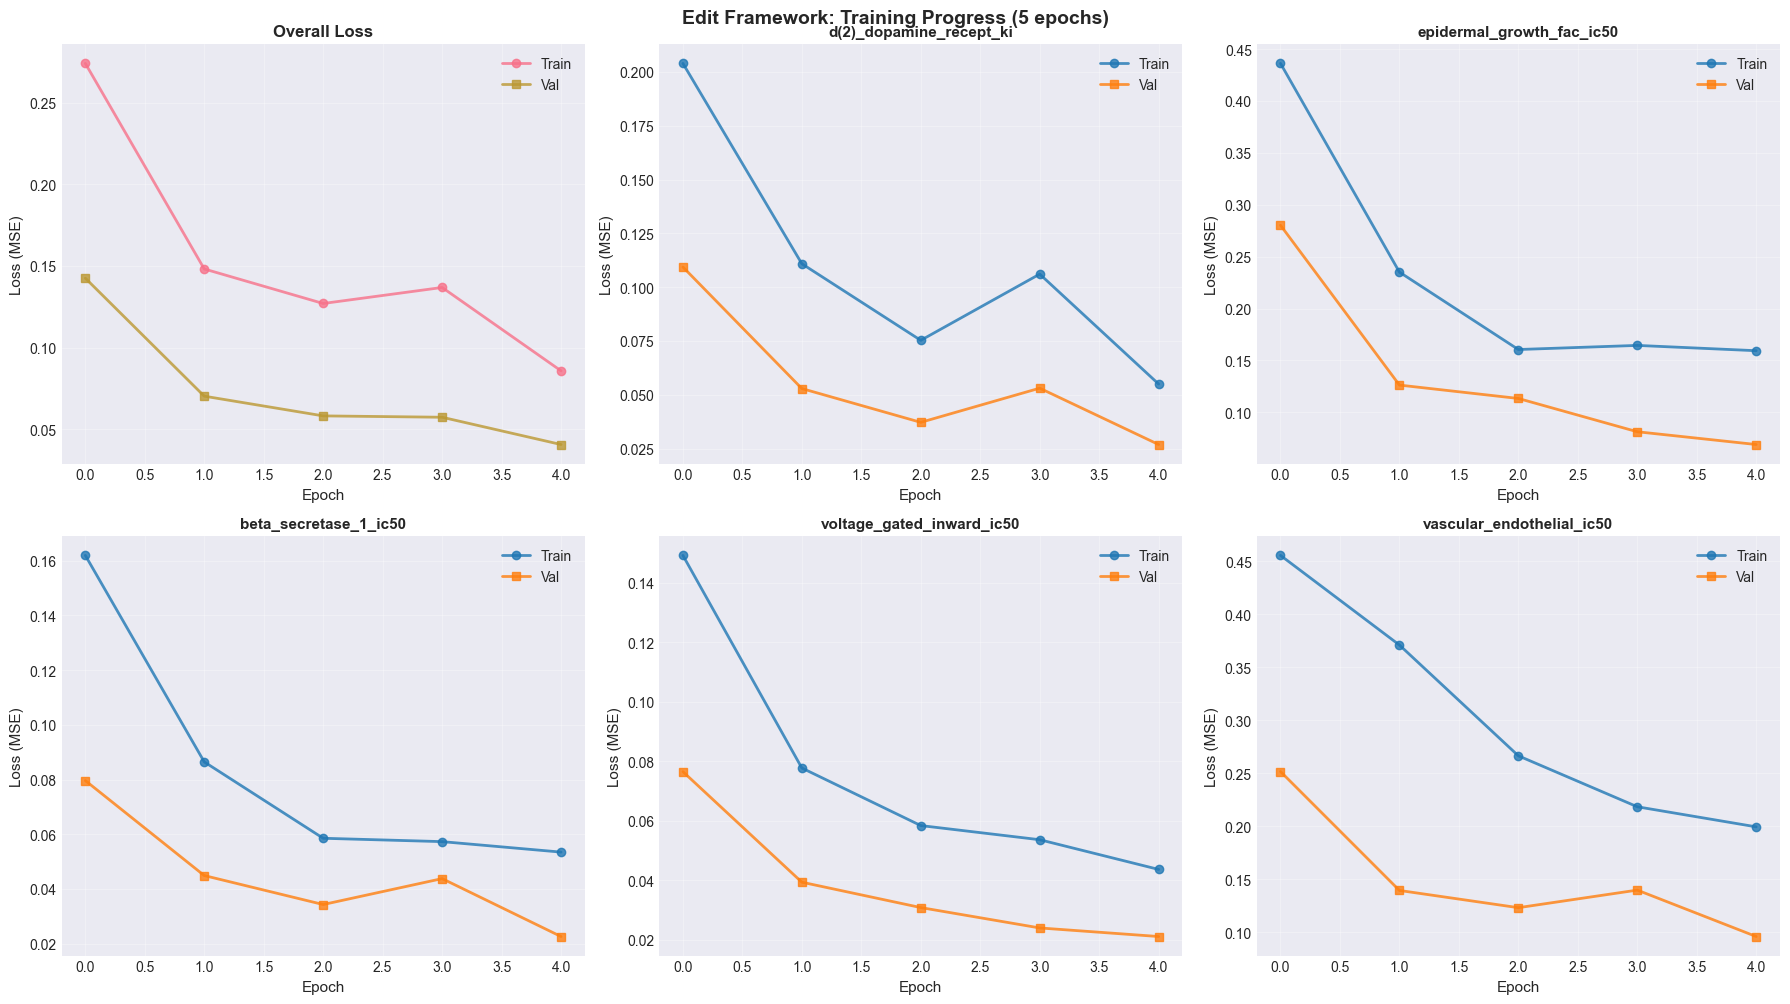


✓ Training history visualized (5 epochs)


In [11]:
# Visualize Edit Framework training progress per epoch
from scripts.plot_training_progress import plot_training_progress_per_epoch

fig, n_epochs = plot_training_progress_per_epoch(
    model=edit_model,
    task_names=selected_properties,
    steps_per_epoch=None  # Auto-calculated
)

if fig is not None:
    plt.suptitle(f'Edit Framework: Training Progress ({n_epochs} epochs)',
                fontsize=14, fontweight='bold', y=1.00)
    plt.show()
    print(f"\n✓ Training history visualized ({n_epochs} epochs)")


## 5. Train Baseline (Multi-Task Property Predictor)

In [12]:
# Train Baseline with pre-computed embeddings
baseline_model = PropertyPredictor(
    embedder=mol_embedder,
    task_names=selected_properties,
    hidden_dims=HIDDEN_DIMS,
    dropout=DROPOUT,
    learning_rate=LEARNING_RATE,
    batch_size=BATCH_SIZE,
    max_epochs=MAX_EPOCHS,
    device=device
)

print("\nTraining Baseline with pre-computed embeddings...")

baseline_model.fit(
    mol_emb_train=mol_emb_baseline_train,
    y_train=y_train_baseline,
    mol_emb_val=mol_emb_baseline_val,
    y_val=y_val_baseline
)

print("\n✓ Baseline trained using cached embeddings")


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
/Users/shaharharel/miniconda3/envs/quris/lib/python3.11/site-packages/pytorch_lightning/trainer/setup.py:166: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.

  | Name               | Type             | Params | Mode 
----------------------------------------------------------------
0 | multi_task_network | MultiTaskNetwork | 1.2 M  | train
----------------------------------------------------------------
1.2 M     Trainable params
0         Non-trainable params
1.2 M     Total params
4.971     Total estimated model params size (MB)
77        Modules in train mode
0         Modules in eval mode



Training Baseline with pre-computed embeddings...
Using pre-computed embeddings for 281584 training molecules
Using pre-computed embeddings for 60344 validation molecules

Model architecture:
  EMBEDDER: Morgan Fingerprint
  Molecule embedding size: 2048
  Molecule embedder: chemprop_v2_morgan_r2_l2048_chiral
  Predictor input: 2048
  Shared backbone: [512, 256, 128, 64]
  Multi-task heads: 10 tasks
    → d(2)_dopamine_recept_ki
    → epidermal_growth_fac_ic50
    → beta_secretase_1_ic50
    → voltage_gated_inward_ic50
    → vascular_endothelial_ic50
    → voltage_gated_inward_ki
    → d(2)_dopamine_recept_ic50
    → tyrosine_protein_kin_ic50
    → beta_secretase_1_ki
    → vascular_endothelial_ki
  Total parameters: 1,242,698

Training for up to 5 epochs...


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/Users/shaharharel/miniconda3/envs/quris/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:433: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=13` in the `DataLoader` to improve performance.
/Users/shaharharel/miniconda3/envs/quris/lib/python3.11/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:433: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=13` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.


Training complete!

✓ Baseline trained using cached embeddings


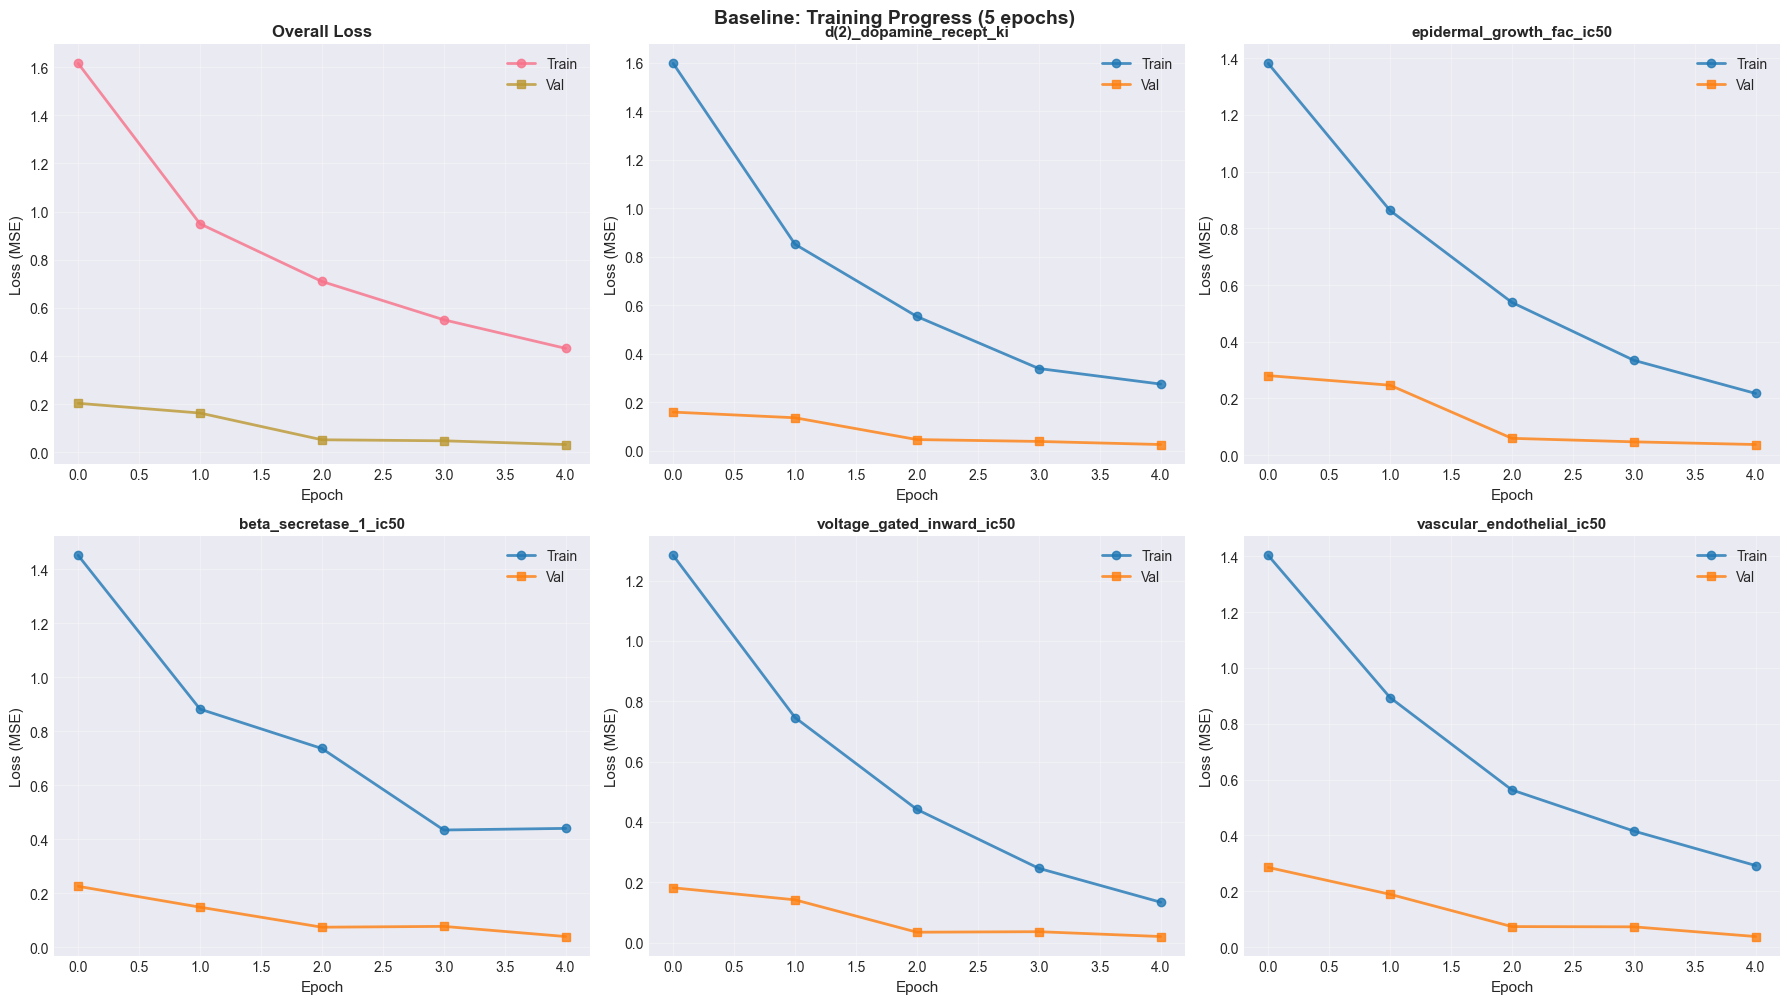


✓ Training history visualized (5 epochs)


In [13]:
# Visualize Baseline training progress per epoch
from scripts.plot_training_progress import plot_training_progress_per_epoch

fig, n_epochs = plot_training_progress_per_epoch(
    model=baseline_model,
    task_names=selected_properties,
    steps_per_epoch=None  # Auto-calculated
)

if fig is not None:
    plt.suptitle(f'Baseline: Training Progress ({n_epochs} epochs)',
                fontsize=14, fontweight='bold', y=1.00)
    plt.show()
    print(f"\n✓ Training history visualized ({n_epochs} epochs)")


### 5.1 Baseline Training Progress

## 6. Evaluation & Comparison


Evaluating Edit Framework
Using pre-computed embeddings for evaluation

  d(2)_dopamine_recept_ki
    N:      6184
    MSE:  0.0265
    RMSE: 0.1628
    MAE:  0.1057
    R²:   0.9418

  epidermal_growth_fac_ic50
    N:      4457
    MSE:  0.0660
    RMSE: 0.2569
    MAE:  0.1860
    R²:   0.9422

  beta_secretase_1_ic50
    N:      1632
    MSE:  0.0273
    RMSE: 0.1652
    MAE:  0.1116
    R²:   0.9557

  voltage_gated_inward_ic50
    N:      8470
    MSE:  0.0226
    RMSE: 0.1503
    MAE:  0.0971
    R²:   0.9477

  vascular_endothelial_ic50
    N:      4465
    MSE:  0.0984
    RMSE: 0.3137
    MAE:  0.2256
    R²:   0.9485

  voltage_gated_inward_ki
    N:      2861
    MSE:  0.0116
    RMSE: 0.1079
    MAE:  0.0795
    R²:   0.9825

  d(2)_dopamine_recept_ic50
    N:       369
    MSE:  0.0747
    RMSE: 0.2733
    MAE:  0.1960
    R²:   0.9379

  tyrosine_protein_kin_ic50
    N:       405
    MSE:  0.0377
    RMSE: 0.1942
    MAE:  0.1192
    R²:   0.9241

  beta_secretase_1_ki
 

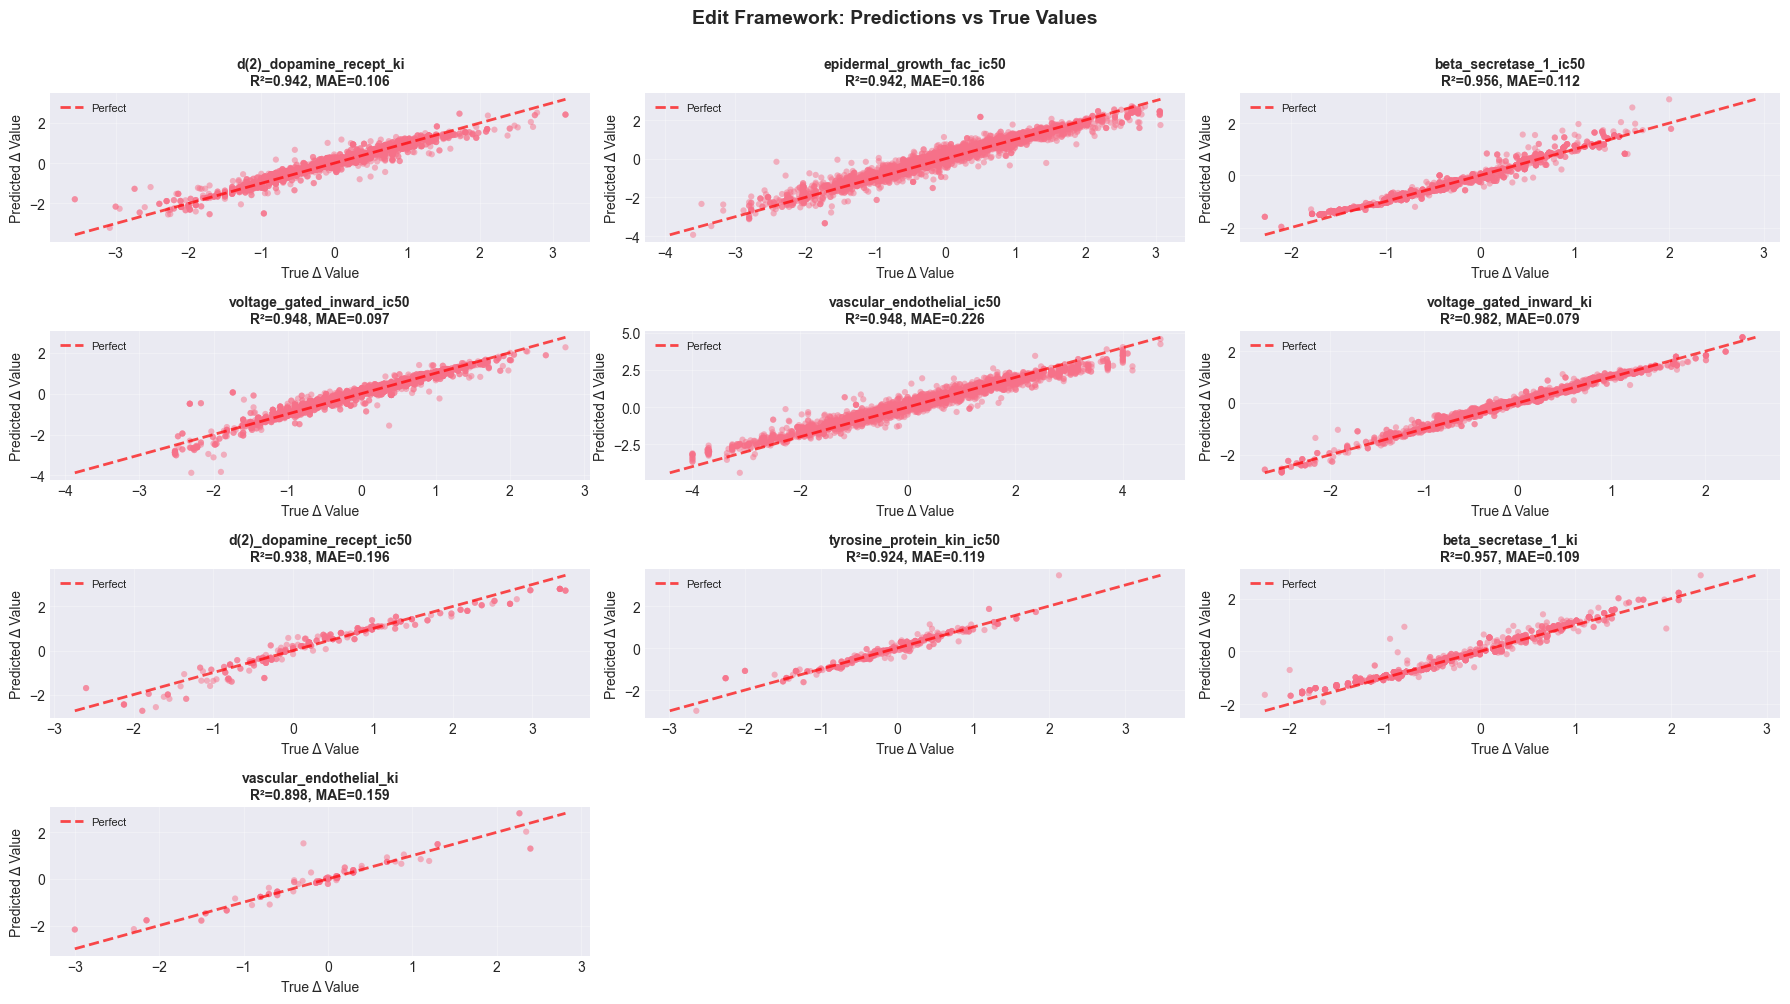

In [ ]:
# Evaluate Edit Framework with pre-computed embeddings
from scripts.evaluate_model import evaluate_multi_task_model, plot_predictions_scatter

edit_metrics, edit_predictions = evaluate_multi_task_model(
    model=edit_model,
    test_data=test_edit,
    task_names=selected_properties,
    model_name="Edit Framework",
    mol_emb_a=mol_emb_a_test,
    mol_emb_b=mol_emb_b_test
)

# Scatter plots
fig = plot_predictions_scatter(
    predictions_dict=edit_predictions,
    model_name="Edit Framework",
    figsize=(18, 10)
)
plt.show()



Evaluating Property Predictor (Baseline)
Using pre-computed embeddings for evaluation

  d(2)_dopamine_recept_ki
    N:     12368
    MSE:  0.0232
    RMSE: 0.1523
    MAE:  0.0922
    R²:   0.9535

  epidermal_growth_fac_ic50
    N:      8914
    MSE:  0.0315
    RMSE: 0.1776
    MAE:  0.1312
    R²:   0.9725

  beta_secretase_1_ic50
    N:      3264
    MSE:  0.0416
    RMSE: 0.2040
    MAE:  0.1486
    R²:   0.9461

  voltage_gated_inward_ic50
    N:     16940
    MSE:  0.0199
    RMSE: 0.1409
    MAE:  0.0847
    R²:   0.9635

  vascular_endothelial_ic50
    N:      8930
    MSE:  0.0401
    RMSE: 0.2001
    MAE:  0.1382
    R²:   0.9770

  voltage_gated_inward_ki
    N:      5722
    MSE:  0.0201
    RMSE: 0.1419
    MAE:  0.1034
    R²:   0.9473

  d(2)_dopamine_recept_ic50
    N:       738
    MSE:  0.1120
    RMSE: 0.3347
    MAE:  0.2671
    R²:   0.9021

  tyrosine_protein_kin_ic50
    N:       810
    MSE:  0.1171
    RMSE: 0.3422
    MAE:  0.2557
    R²:   0.8522

  beta_s

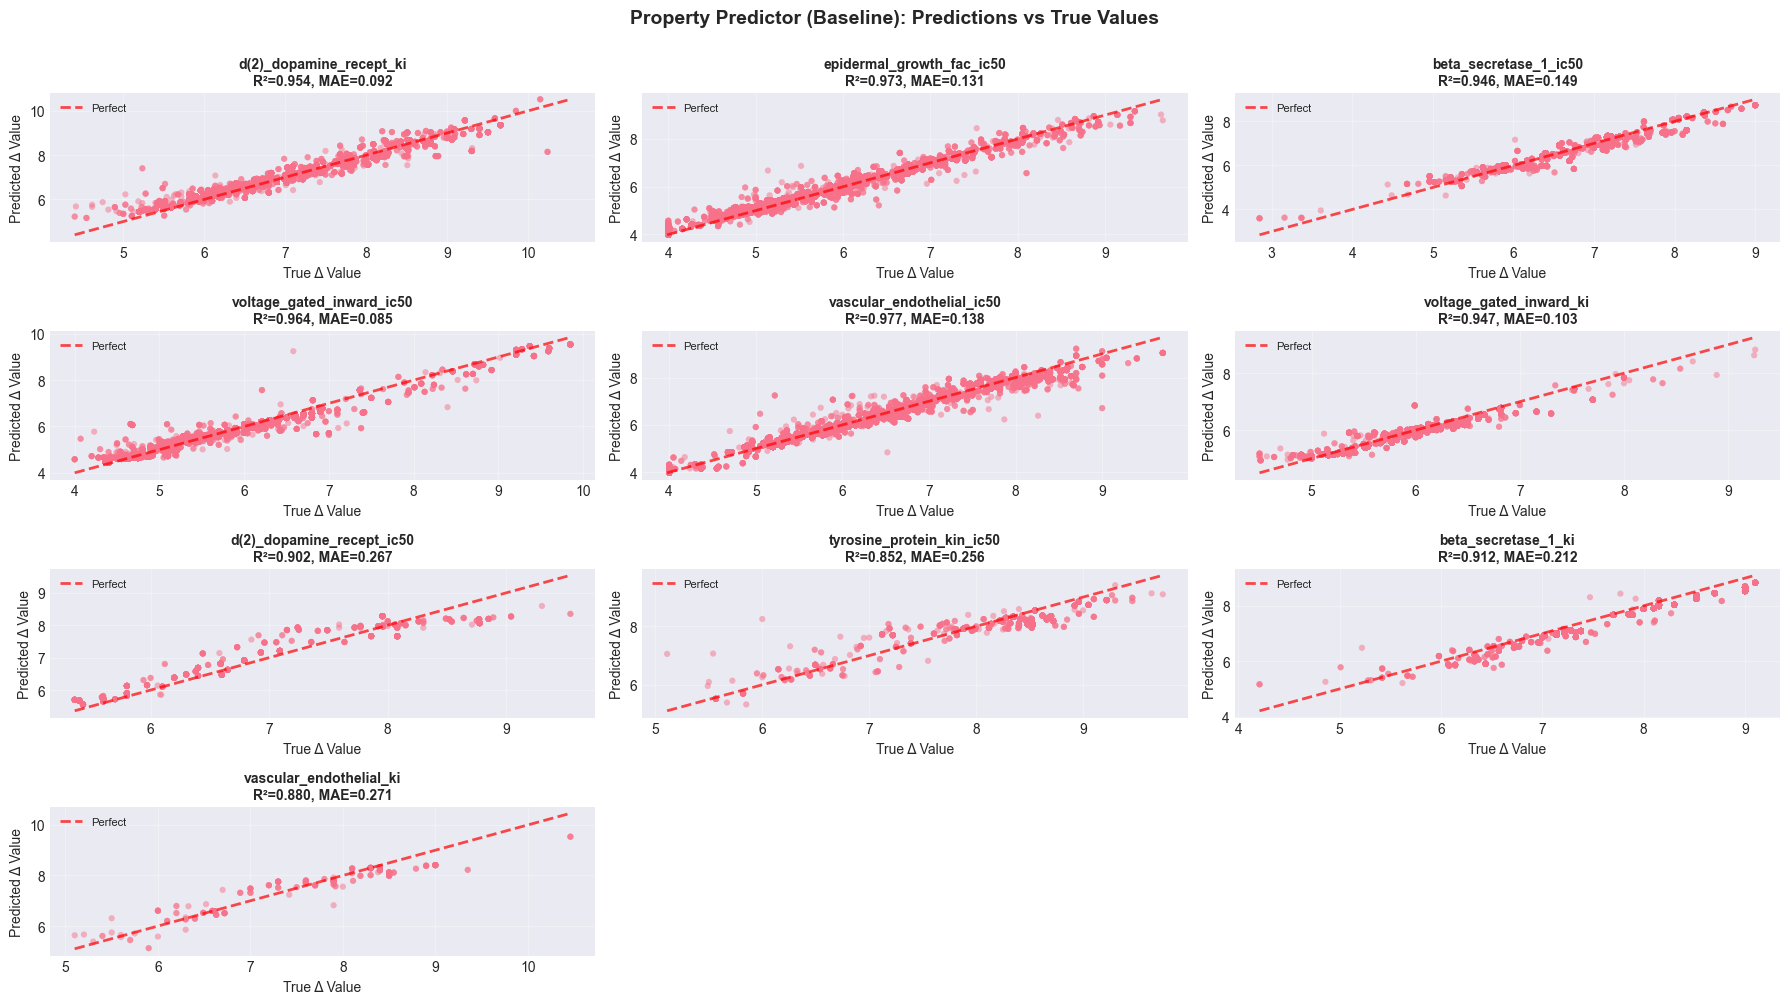

In [15]:
# Evaluate Baseline with pre-computed embeddings
from scripts.evaluate_model import evaluate_multi_task_model, plot_predictions_scatter

baseline_metrics, baseline_predictions = evaluate_multi_task_model(
    model=baseline_model,
    test_data=test_baseline,
    task_names=selected_properties,
    model_name="Property Predictor (Baseline)",
    mol_emb=mol_emb_baseline_test
)

# Scatter plots
fig = plot_predictions_scatter(
    predictions_dict=baseline_predictions,
    model_name="Property Predictor (Baseline)",
    figsize=(18, 10)
)
plt.show()


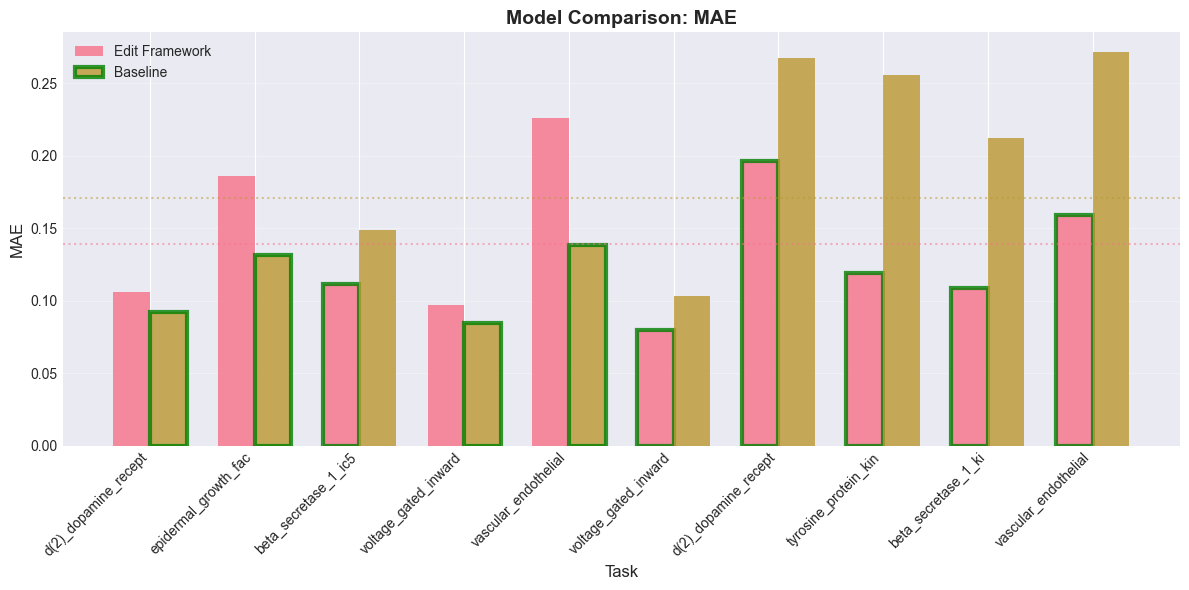

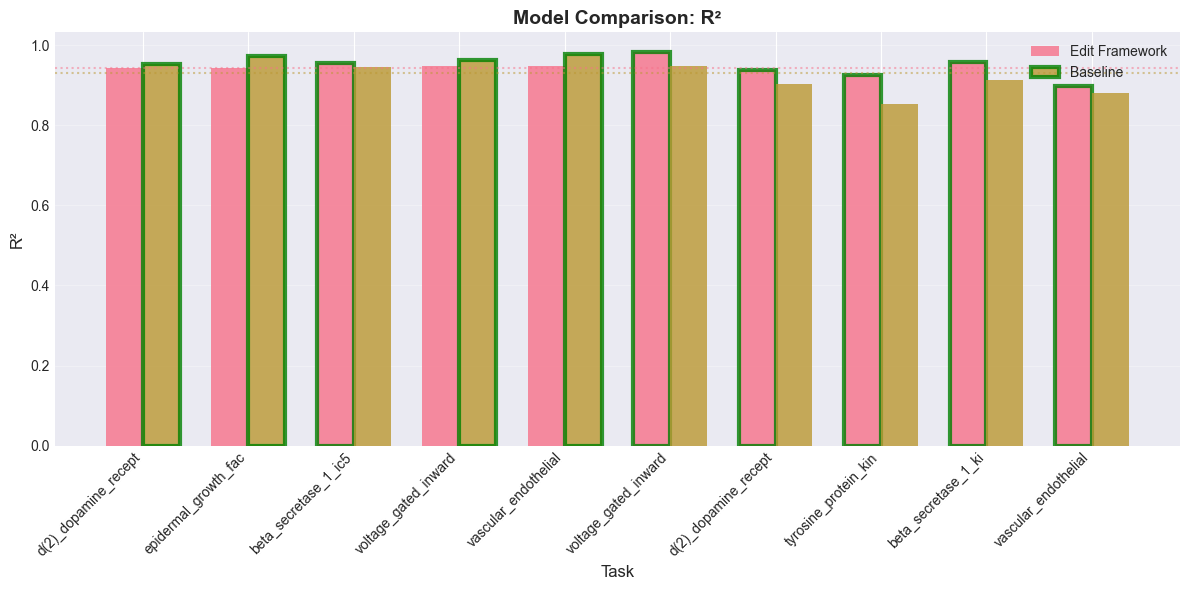


SUMMARY: Edit Framework vs Baseline
Edit Framework MSE:  0.0481
Baseline MSE:        0.0594
Improvement:         +19.0%

Edit Framework MAE:  0.1388
Baseline MAE:        0.1705
Improvement:         +18.6%

Edit Framework R²:   0.9435
Baseline R²:         0.9306
Improvement:         +0.0129


In [ ]:
# Compare models side-by-side
from scripts.evaluate_model import compare_models

# MSE comparison
fig = compare_models(
    metrics_1=edit_metrics,
    metrics_2=baseline_metrics,
    name_1="Edit Framework",
    name_2="Baseline",
    metric='MAE',
    figsize=(12, 6)
)
plt.show()

# R² comparison
fig = compare_models(
    metrics_1=edit_metrics,
    metrics_2=baseline_metrics,
    name_1="Edit Framework",
    name_2="Baseline",
    metric='R²',
    figsize=(12, 6)
)
plt.show()

# Calculate summary metrics
avg_mse_edit = edit_metrics['MSE'].mean()
avg_mse_baseline = baseline_metrics['MSE'].mean()
avg_mae_edit = edit_metrics['MAE'].mean()
avg_mae_baseline = baseline_metrics['MAE'].mean()
avg_r2_edit = edit_metrics['R²'].mean()
avg_r2_baseline = baseline_metrics['R²'].mean()

mse_improvement = ((avg_mse_baseline - avg_mse_edit) / avg_mse_baseline) * 100
mae_improvement = ((avg_mae_baseline - avg_mae_edit) / avg_mae_baseline) * 100
r2_improvement = avg_r2_edit - avg_r2_baseline

# Summary
print("\n" + "="*70)
print("SUMMARY: Edit Framework vs Baseline")
print("="*70)
print(f"Edit Framework MSE:  {avg_mse_edit:.4f}")
print(f"Baseline MSE:        {avg_mse_baseline:.4f}")
print(f"Improvement:         {mse_improvement:+.1f}%")
print()
print(f"Edit Framework MAE:  {avg_mae_edit:.4f}")
print(f"Baseline MAE:        {avg_mae_baseline:.4f}")
print(f"Improvement:         {mae_improvement:+.1f}%")
print()
print(f"Edit Framework R²:   {avg_r2_edit:.4f}")
print(f"Baseline R²:         {avg_r2_baseline:.4f}")
print(f"Improvement:         {r2_improvement:+.4f}")
print("="*70)


## 7. Analyze Shared Edit Embeddings

In [ ]:
# Extract unique edit embeddings from Edit Framework
print("Extracting unique edit embeddings...\n")

# Get edit layer
edit_layer = edit_model.model.trainable_edit_layer

# Use pre-computed embeddings (already encoded)
reactant_tensor = torch.FloatTensor(mol_emb_a_test).to(device)
product_tensor = torch.FloatTensor(mol_emb_b_test).to(device)

edit_layer.eval()
with torch.no_grad():
    all_edit_emb = edit_layer(reactant_tensor, product_tensor).cpu().numpy()

# Get unique edits - same edit always produces same embedding
# So we just need one embedding per unique edit name
unique_edits = test_edit['edit_name'].unique()
edit_to_idx = {edit: test_edit[test_edit['edit_name'] == edit].index[0] 
               for edit in unique_edits}

# Extract one embedding per unique edit
edit_embeddings = np.array([all_edit_emb[idx] for idx in edit_to_idx.values()])
edit_names = list(edit_to_idx.keys())

print(f"Total test pairs: {len(all_edit_emb)}")
print(f"Unique edits: {len(edit_names)}")
print(f"Edit embedding shape: {edit_embeddings.shape}")
print(f"\nNote: Same edit (mol_a → mol_b) always produces same embedding across all tasks")


Extracting unique edit embeddings...

Total test pairs: 30173
Unique edits: 7140
Edit embedding shape: (7140, 2048)

Note: Same edit (mol_a → mol_b) always produces same embedding across all tasks


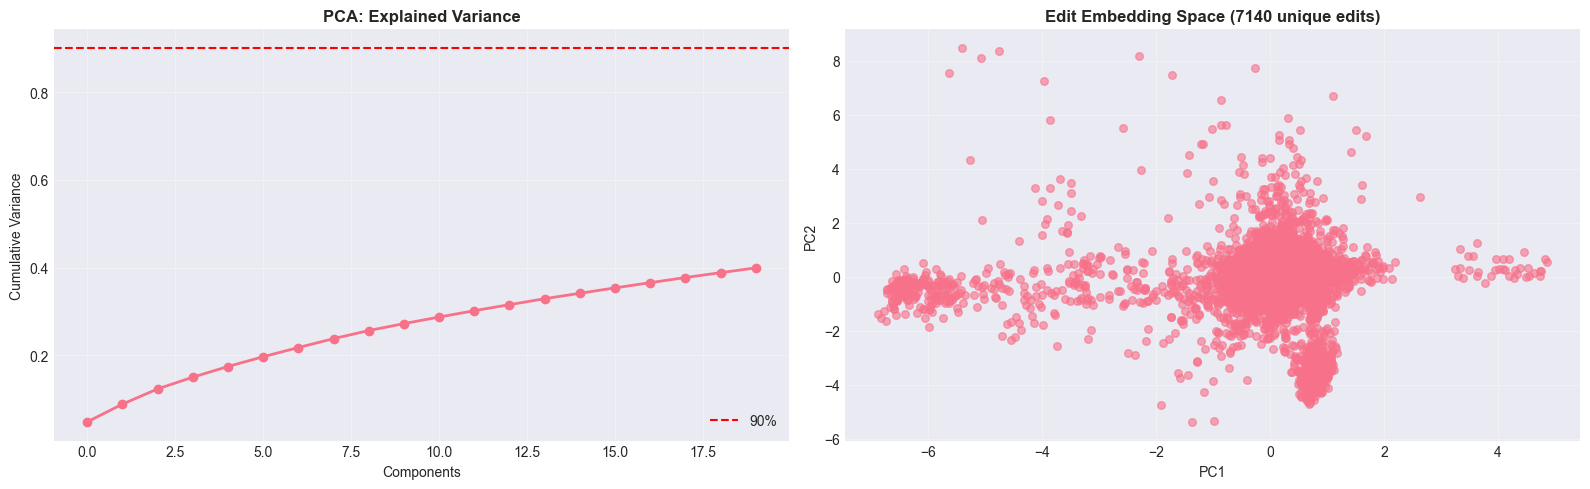


First 10 PCs: 27.2% variance
First 2 PCs: 8.9% variance


In [18]:
# PCA of unique edit embeddings
pca = PCA(n_components=min(50, edit_embeddings.shape[0]))
edit_pca = pca.fit_transform(edit_embeddings)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 5))

# Scree plot
ax1.plot(np.cumsum(pca.explained_variance_ratio_[:20]), 'o-', linewidth=2)
ax1.set_xlabel('Components')
ax1.set_ylabel('Cumulative Variance')
ax1.set_title('PCA: Explained Variance', fontweight='bold')
ax1.grid(alpha=0.3)
ax1.axhline(0.9, color='r', linestyle='--', label='90%')
ax1.legend()

# PC1 vs PC2 scatter
ax2.scatter(edit_pca[:, 0], edit_pca[:, 1], alpha=0.6, s=30)
ax2.set_xlabel('PC1')
ax2.set_ylabel('PC2')
ax2.set_title(f'Edit Embedding Space ({len(edit_names)} unique edits)', fontweight='bold')
ax2.grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nFirst 10 PCs: {pca.explained_variance_ratio_[:10].sum():.1%} variance")
print(f"First 2 PCs: {pca.explained_variance_ratio_[:2].sum():.1%} variance")


## 8. Edit Effect Analysis Across Properties

In [ ]:
# Analyze most frequent edits and their effects
print("Analyzing edit effects across properties...\n")

# Get edit effects per property
edit_effects = {}
for i, prop in enumerate(selected_properties):
    mask = (test_edit['property_idx'] == i)
    prop_test = test_edit[mask]
    edit_avg = prop_test.groupby('edit_name')['delta'].mean()
    edit_effects[prop] = edit_avg.to_dict()

# Get most frequent edits (by occurrence count across all properties)
edit_counts = test_edit.groupby('edit_name').size().sort_values(ascending=False)

# Take top 20 most frequent edits
n_top_edits = min(20, len(edit_counts))
top_edit_names = edit_counts.head(n_top_edits).index.tolist()

print(f"Analyzing top {len(top_edit_names)} most frequent edits:")
for i, edit in enumerate(top_edit_names[:5], 1):
    count = edit_counts[edit]
    print(f"  {i}. {edit[:50]}: {count} occurrences")
print(f"  ...")

# Build effect matrix (top edits × properties)
effect_matrix = np.full((len(top_edit_names), NUM_TASKS), np.nan)
for i, edit in enumerate(top_edit_names):
    for j, prop in enumerate(selected_properties):
        if edit in edit_effects[prop]:
            effect_matrix[i, j] = edit_effects[prop][edit]

print(f"\nEffect matrix shape: {effect_matrix.shape}")


Analyzing edit effects across properties...

Analyzing top 20 most frequent edits:
  1. F_to_Cl_exchange: 86 occurrences
  2. c1ccccc1>>Fc1ccccc1: 74 occurrences
  3. FC(F)(F)c1ccccc1>>Fc1cccc(C(F)(F)F)c1: 72 occurrences
  4. Fc1ccccc1>>Fc1ccccc1: 72 occurrences
  5. homologation_C1_to_C2: 70 occurrences
  ...

Effect matrix shape: (20, 10)


### 8.1 Hierarchical Clustering on PCA Space


Clustering top 20 most frequent edits:
  1. Clc1ccccc1>>FC(F)(F)Oc1ccccc1: 52 occurrences
  2. Clc1ccccc1>>FC(F)(F)c1ccccc1: 65 occurrences
  3. Fc1cccc(C(F)(F)F)c1>>FS(F)(F)(F)(F)c1ccccc1: 49 occurrences
  4. Fc1ccccc1C(F)(F)F>>Fc1cccc(C(F)(F)F)c1: 50 occurrences
  5. Cl_to_F_exchange: 49 occurrences
  ...


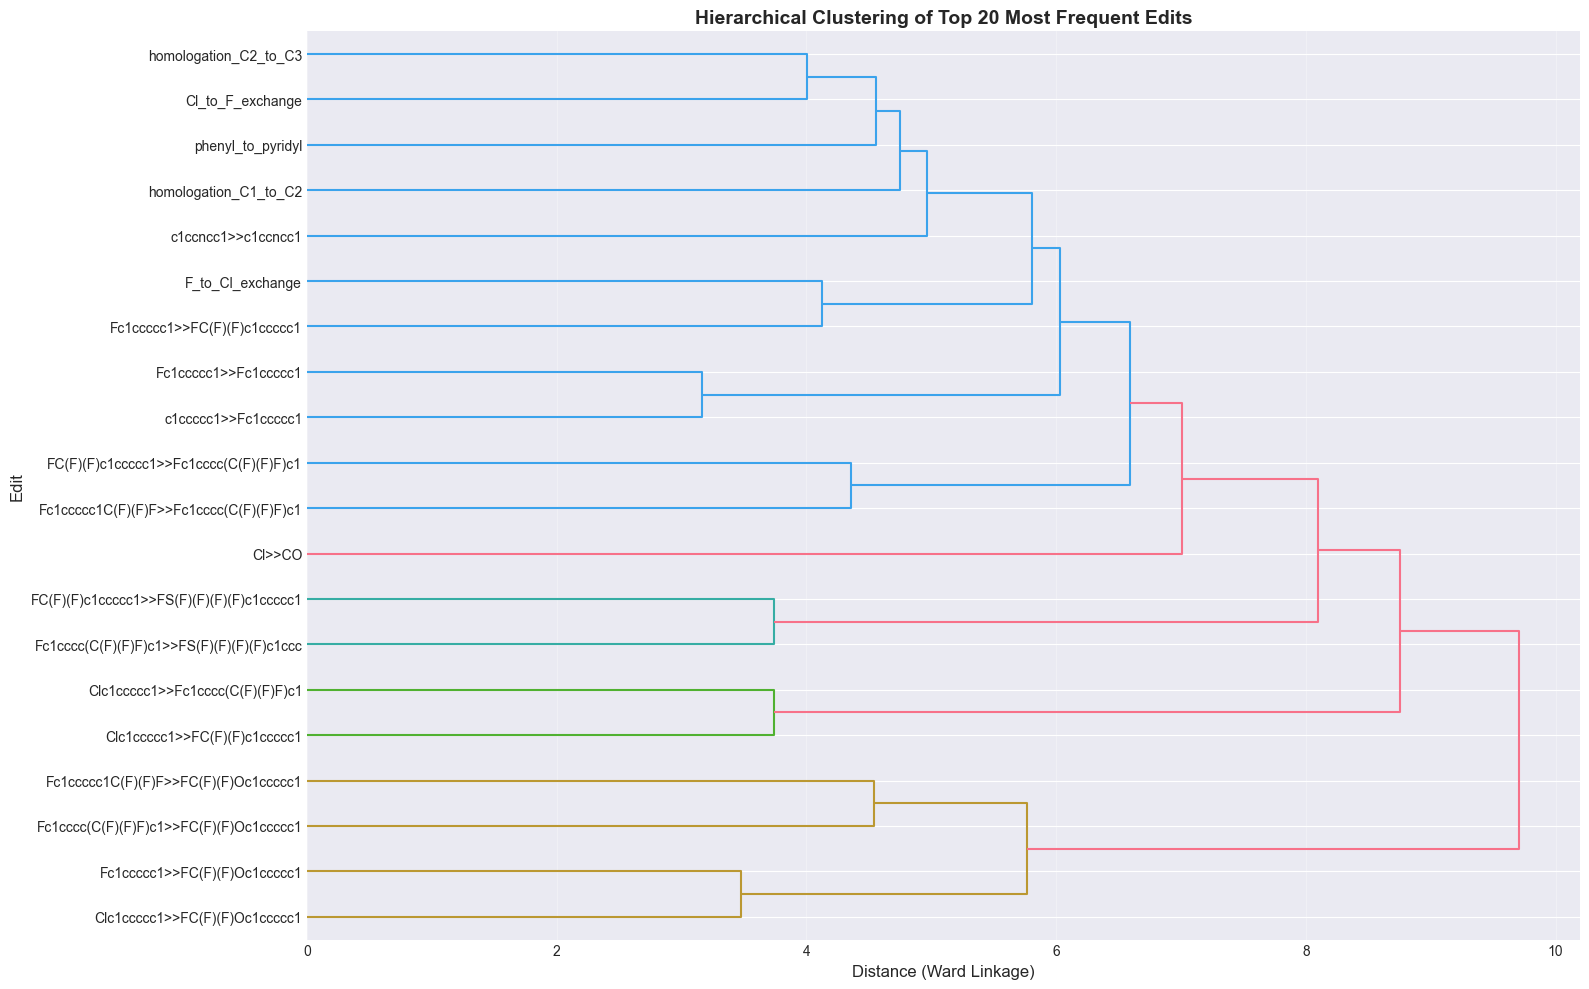


✓ Hierarchical clustering on full embedding space
  Linkage: Ward (minimizes within-cluster variance)
  Distance metric: Euclidean on learned edit embeddings


In [32]:
# Hierarchical clustering on top 20 most frequent edits
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import pdist

# Get top 20 most frequent edits from test set
edit_counts_full = test_edit.groupby('edit_name').size().sort_values(ascending=False)
top_20_edits = edit_counts_full.head(20).index.tolist()

# Get indices of top 20 edits in our edit_names list
top_20_indices = [i for i, name in enumerate(edit_names) if name in top_20_edits]
top_20_edit_names = [edit_names[i] for i in top_20_indices]

print(f"Clustering top {len(top_20_edit_names)} most frequent edits:")
for i, edit in enumerate(top_20_edit_names[:5], 1):
    count = edit_counts_full[edit]
    print(f"  {i}. {edit[:50]}: {count} occurrences")
print("  ...")

# Get embeddings for top 20 edits (use full embedding space, not PCA)
top_20_embeddings = edit_embeddings[top_20_indices]

# Compute linkage on full embedding space
linkage_matrix = linkage(top_20_embeddings, method='ward')

# Plot dendrogram with edit names as labels
fig, ax = plt.subplots(figsize=(16, 10))

dendrogram(
    linkage_matrix,
    ax=ax,
    labels=[name[:40] for name in top_20_edit_names],  # Truncate long names
    orientation='right',
    leaf_font_size=10
)

ax.set_xlabel('Distance (Ward Linkage)', fontsize=12)
ax.set_ylabel('Edit', fontsize=12)
ax.set_title(f'Hierarchical Clustering of Top {len(top_20_edit_names)} Most Frequent Edits',
            fontsize=14, fontweight='bold')
ax.grid(alpha=0.3, axis='x')
plt.tight_layout()
plt.show()

print(f"\n✓ Hierarchical clustering on full embedding space")
print(f"  Linkage: Ward (minimizes within-cluster variance)")
print(f"  Distance metric: Euclidean on learned edit embeddings")


## 9. Summary

In [ ]:
print("MULTI-TASK EDIT CALCULUS: SUMMARY")

print(f"\n📊 Dataset:")

print(f"\n🏗 Architecture:")
print(f"  Edit Framework:")
print(f"    - Shared edit embeddings: {TRAINABLE_EDIT_DIMS}")
print(f"    - Shared backbone: {HIDDEN_DIMS}")
print(f"    - Multi-task head: {NUM_TASKS} tasks")
print(f"  Baseline:")
print(f"    - Shared backbone: {HIDDEN_DIMS}")
print(f"    - Multi-task head: {NUM_TASKS} tasks")
print(f"    - Computes Δ via subtraction")

print(f"\n📈 Performance Comparison:")
print(f"  Edit Framework: MAE={avg_mae_edit:.4f}, R²={avg_r2_edit:.4f}")
print(f"  Baseline:       MAE={avg_mae_baseline:.4f}, R²={avg_r2_baseline:.4f}")
print(f"  Improvement:    MAE {mae_improvement:+.1f}%, R² {r2_improvement:+.4f}")

# Check if edit analysis was performed (top_edit_names defined in cell 33)
try:
    if len(top_edit_names) > 0:
        print(f"\n🔬 Edit Analysis: {len(top_edit_names)} common edits analyzed")
except NameError:
    pass

if mae_improvement > 5 and r2_improvement > 0.05:
    print("\n✓ CONCLUSION: Shared edit embeddings significantly improve prediction!")
    print("  Learning edit patterns across tasks transfers knowledge effectively.")
elif mae_improvement > 0 or r2_improvement > 0:
    print("\n~ CONCLUSION: Shared edit embeddings show modest improvements.")
    print("  Edit-based learning has some advantages over direct property prediction.")
else:
    print("\n⚠ CONCLUSION: Baseline performs better.")
    print("  Property-based learning may be more effective for this data.")


MULTI-TASK EDIT CALCULUS: SUMMARY

📊 Dataset:

🏗 Architecture:
  Edit Framework:
    - Shared edit embeddings: [1024, 512]
    - Shared backbone: [512, 256, 128, 64]
    - Multi-task head: 10 tasks
  Baseline:
    - Shared backbone: [512, 256, 128, 64]
    - Multi-task head: 10 tasks
    - Computes Δ via subtraction

📈 Performance Comparison:
  Edit Framework: MAE=0.3408, R²=0.7192
  Baseline:       MAE=0.3659, R²=0.6889
  Improvement:    MAE +6.9%, R² +0.0304

🔬 Edit Analysis: 20 common edits analyzed

~ CONCLUSION: Shared edit embeddings show modest improvements.
  Edit-based learning has some advantages over direct property prediction.
